In [1]:
!pip3 install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip3 install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=a61e166684db38ded418467dbb01f5ff3b059187775117c61008965d97aef13b
  Stored in directory: /root/.cache/pip/wheels/be/7b/04/4d8d56f1d503e5c404f0de6018c0cfa592c71588a39b49e002
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0


In [3]:
!pip install --upgrade imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 50.5 MB/s eta 0:00:00


In [4]:
! pip3 install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML



Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2482176/45929032 bytes (5.4%)5963776/45929032 bytes (13.0%)9240576/45929032 bytes (20.1%)12263424/45929032 bytes (26.7%)15278080/45929032 bytes (33.3%)18366464/45929032 bytes (40.0%)21512192/45929032 bytes (46.8%)24961024/45929032 bytes (54.3%)28270592/45929032 bytes (61.6%)31531008/45929032 bytes (68.7%)34603008/45929032 bytes (75.3%)37724160/45929032 bytes (82.1%)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
imageDir = '/content/drive/MyDrive/lane line/test_images/'
imageFiles = os.listdir(imageDir)

imageList = []

for i in range(0, len(imageFiles)):
    imageList.append(mpimg.imread(imageDir + imageFiles[i]))

print(imageFiles)

['solidWhiteCurve.jpg', 'whiteCarLaneSwitch.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'solidYellowLeft.jpg']


In [8]:
def display_images(images, cmap=None):
    plt.figure(figsize=(40,40))    
    for i, image in enumerate(images):
        plt.subplot(3,2,i+1)
        plt.imshow(image, cmap)
        plt.autoscale(tight=True)
    plt.show()
    
display_images(imageList)

In [9]:
def color_filter(image):
    #convert to HLS to mask based on HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lower = np.array([0,190,0])
    upper = np.array([255,255,255])
    
    yellower = np.array([10,0,90])
    yelupper = np.array([50,255,255])
    
    yellowmask = cv2.inRange(hls, yellower, yelupper)    
    whitemask = cv2.inRange(hls, lower, upper)
    
    mask = cv2.bitwise_or(yellowmask, whitemask)  
    masked = cv2.bitwise_and(image, image, mask = mask)    
    


    return masked

filtered_img = list(map(color_filter, imageList))

display_images(filtered_img)


In [10]:
def roi(img):
    x = int(img.shape[1])
    y = int(img.shape[0])
    shape = np.array([[int(0), int(y)], [int(x), int(y)], [int(0.55*x), int(0.6*y)], [int(0.45*x), int(0.6*y)]])

    #define a numpy array with the dimensions of img, but comprised of zeros
    mask = np.zeros_like(img)

    #Uses 3 channels or 1 channel for color depending on input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #creates a polygon with the mask color
    cv2.fillPoly(mask, np.int32([shape]), ignore_mask_color)

    #returns the image only where the mask pixels are not zero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

roi_img = list(map(roi, filtered_img))

display_images(roi_img)

In [11]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img):
    return cv2.Canny(grayscale(img), 50, 120)

canny_img = list(map(canny, roi_img))
display_images(canny_img,cmap='gray')

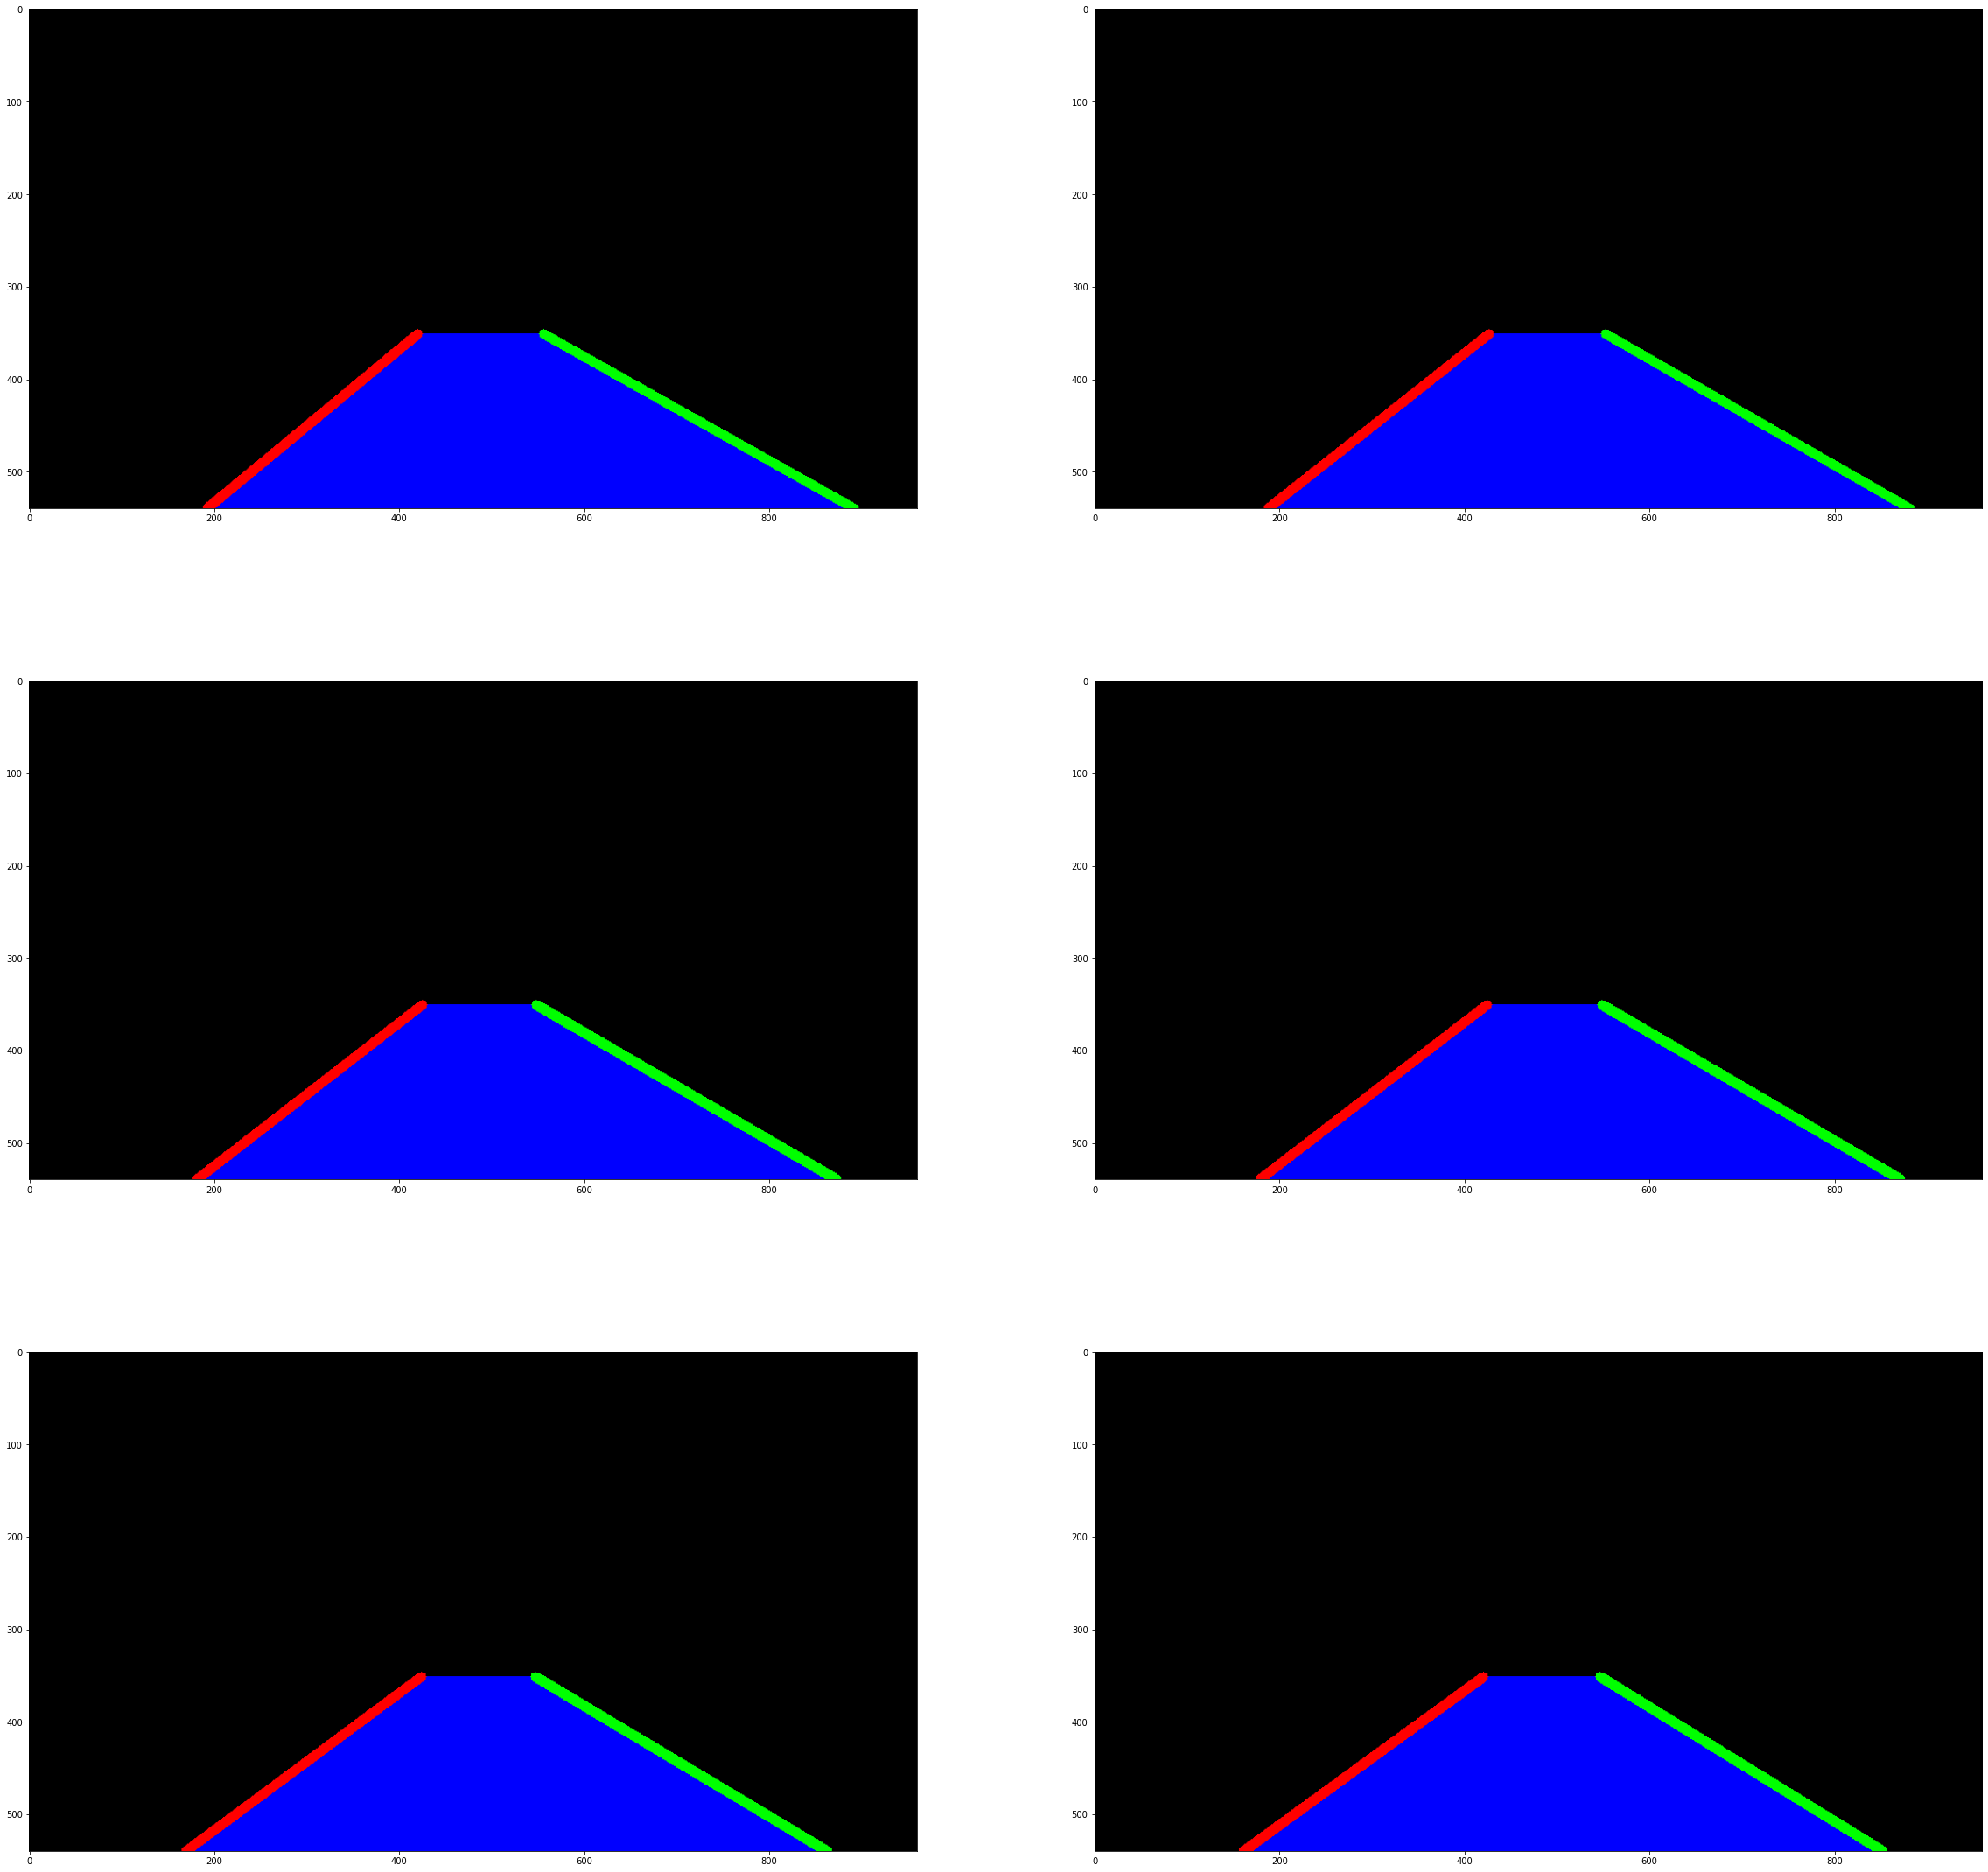

In [12]:
rightSlope, leftSlope, rightIntercept, leftIntercept = [],[],[],[]
def draw_lines(img, lines, thickness=5):
    global rightSlope, leftSlope, rightIntercept, leftIntercept
    rightColor=[0,255,0]
    leftColor=[255,0,0]
    
    #this is used to filter out the outlying lines that can affect the average
    #We then use the slope we determined to find the y-intercept of the filtered lines by solving for b in y=mx+b
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            if slope > 0.3:
                if x1 > 500 :
                    yintercept = y2 - (slope*x2)                    
                    rightSlope.append(slope)
                    rightIntercept.append(yintercept)
                else: None                
            elif slope < -0.3:
                if x1 < 600:
                    yintercept = y2 - (slope*x2)                    
                    leftSlope.append(slope)
                    leftIntercept.append(yintercept)    
                    
                    
    #We use slicing operators and np.mean() to find the averages of the 30 previous frames
    #This makes the lines more stable, and less likely to shift rapidly
    leftavgSlope = np.mean(leftSlope[-30:])
    leftavgIntercept = np.mean(leftIntercept[-30:])
    
    rightavgSlope = np.mean(rightSlope[-30:])
    rightavgIntercept = np.mean(rightIntercept[-30:])
    
    
    #Here we plot the lines and the shape of the lane using the average slope and intercepts
    try:
        left_line_x1 = int((0.65*img.shape[0] - leftavgIntercept)/leftavgSlope)
        left_line_x2 = int((img.shape[0] - leftavgIntercept)/leftavgSlope)
    
        right_line_x1 = int((0.65*img.shape[0] - rightavgIntercept)/rightavgSlope)
        right_line_x2 = int((img.shape[0] - rightavgIntercept)/rightavgSlope)

        pts = np.array([[left_line_x1, int(0.65*img.shape[0])],[left_line_x2, int(img.shape[0])],[right_line_x2, int(img.shape[0])],[right_line_x1, int(0.65*img.shape[0])]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(img,[pts],(0,0,255))      
        
        
        cv2.line(img, (left_line_x1, int(0.65*img.shape[0])), (left_line_x2, int(img.shape[0])), leftColor, 10)
        cv2.line(img, (right_line_x1, int(0.65*img.shape[0])), (right_line_x2, int(img.shape[0])), rightColor, 10)
    except ValueError:
            
        pass
    
    
    
                
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def linedetect(img):
    return hough_lines(img, 1, np.pi/180, 10, 20, 100)

hough_img = list(map(linedetect, canny_img))
display_images(hough_img)

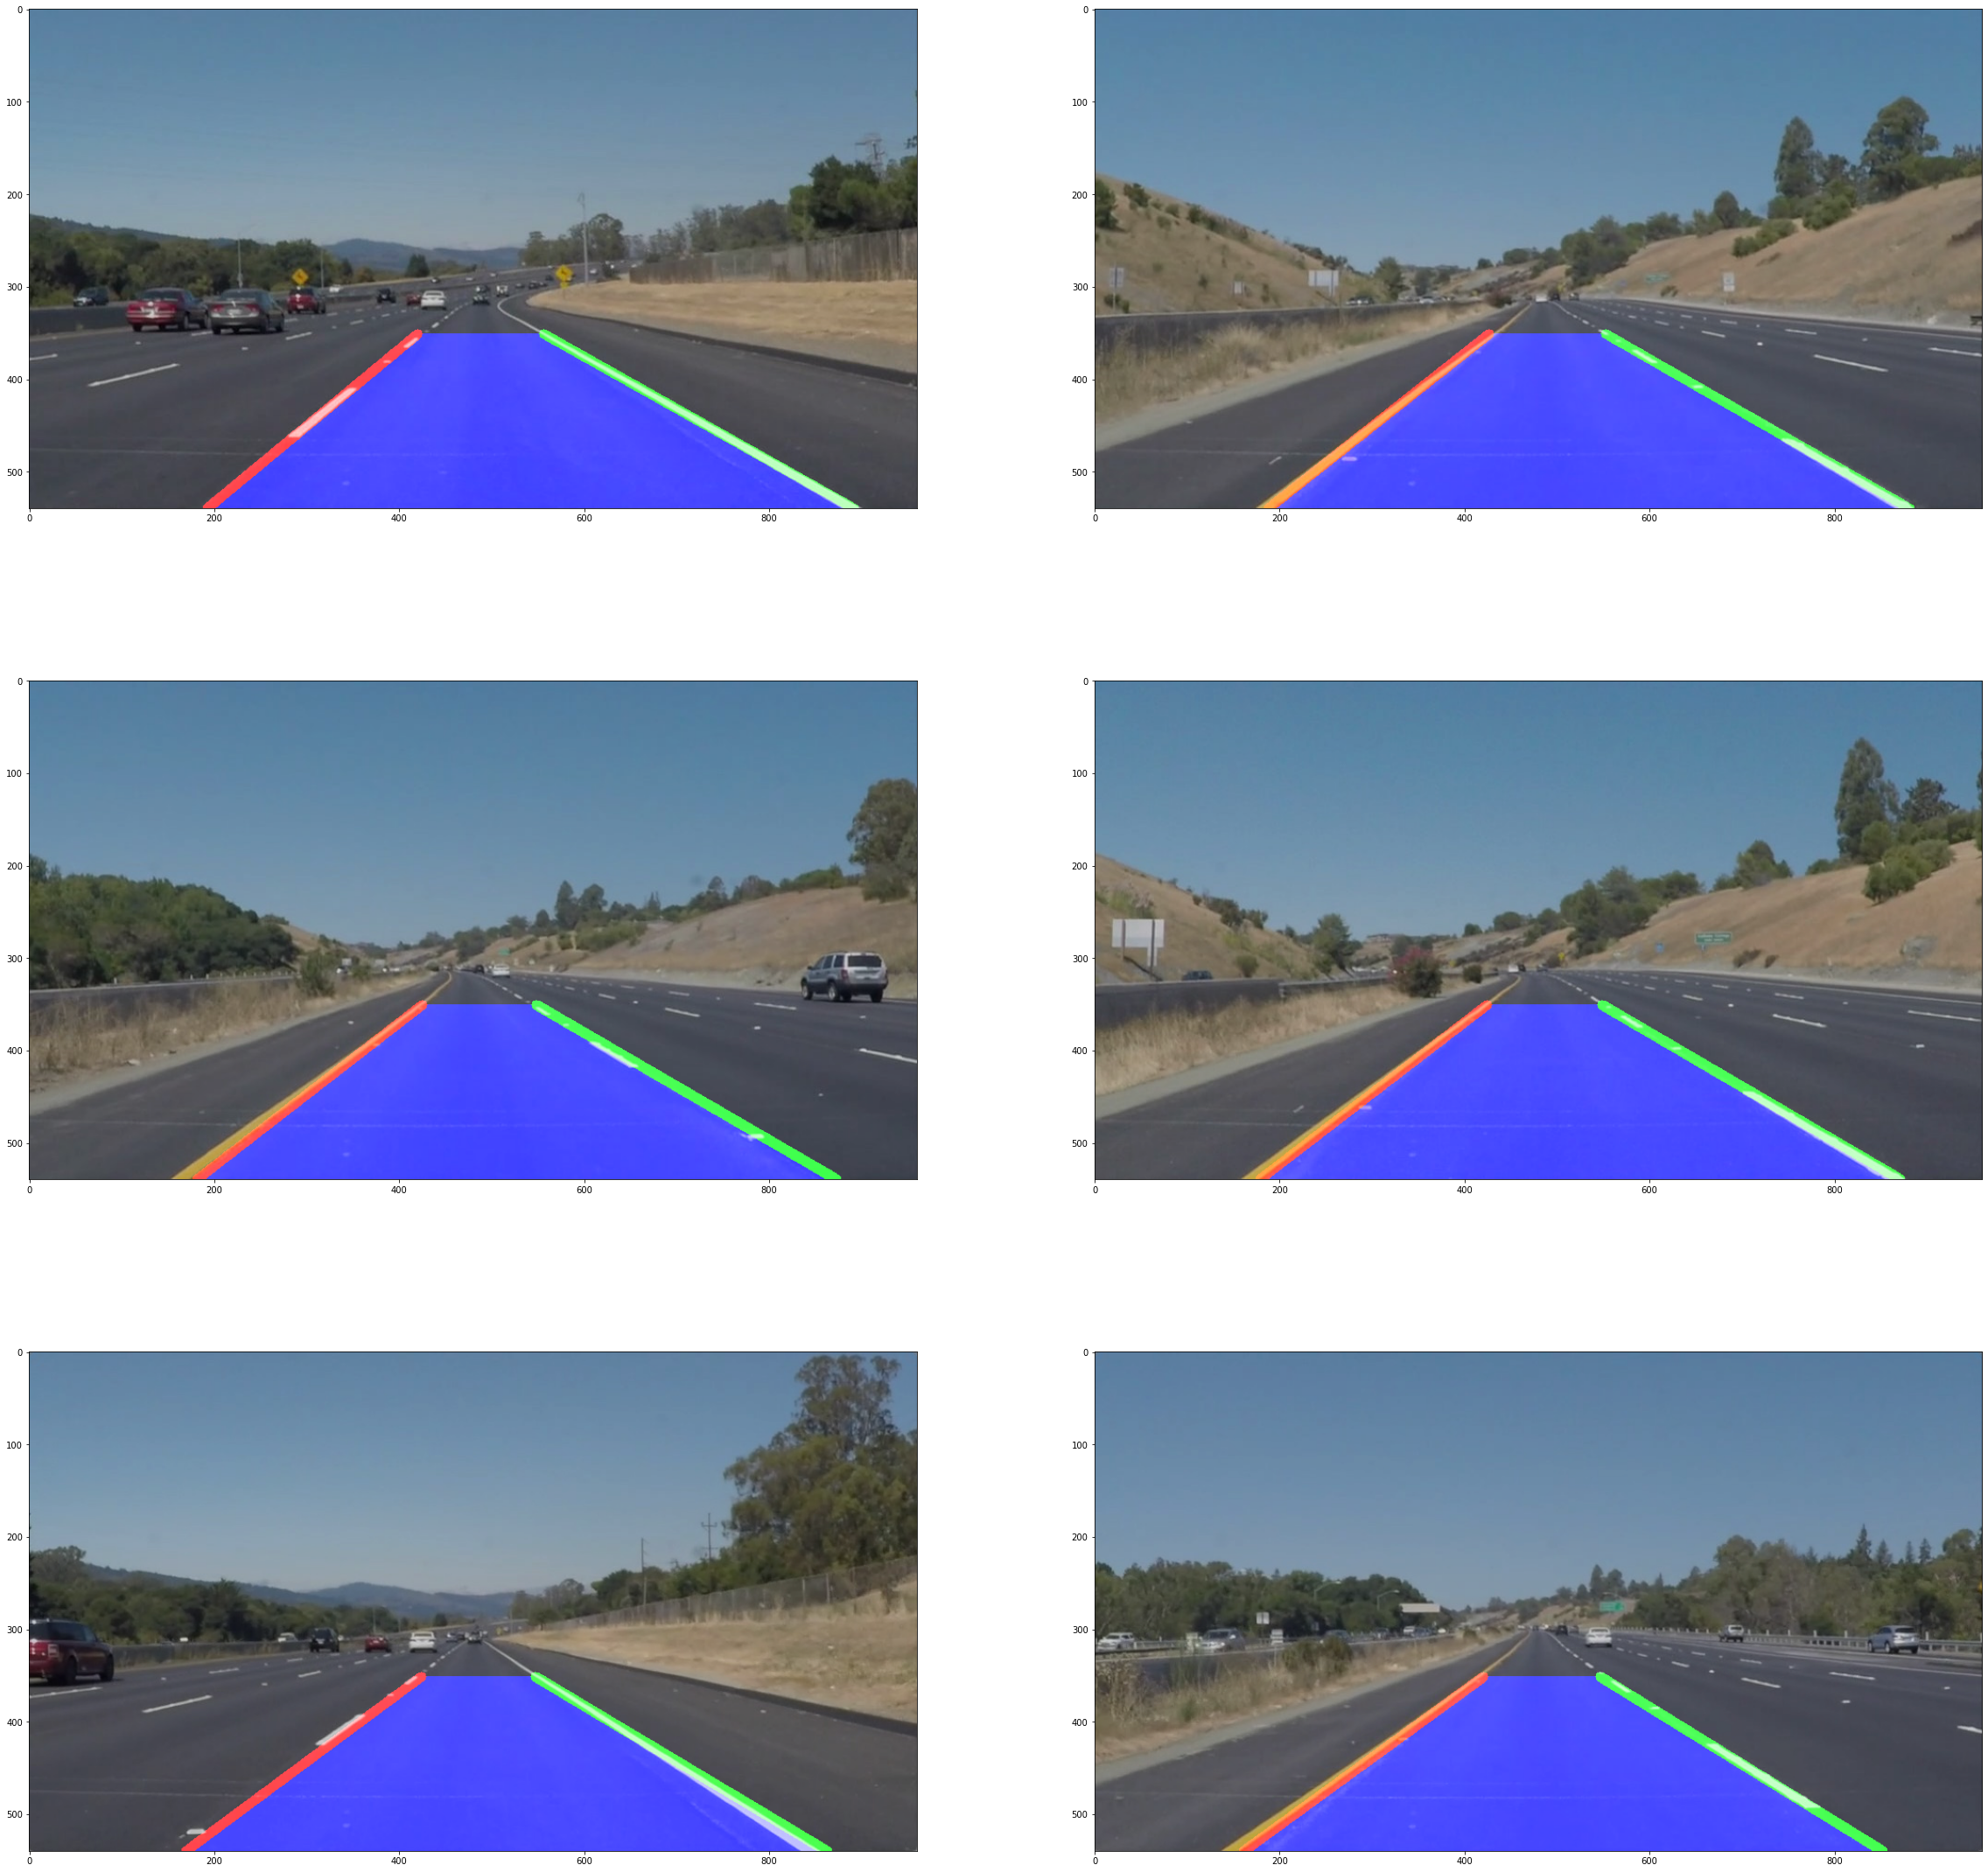

In [13]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def weightSum(input_set):
    img = list(input_set)
    return cv2.addWeighted(img[0], 1, img[1], 0.8, 0)

result_img = list(map(weightSum, zip(hough_img, imageList)))
display_images(result_img)

In [14]:
def processImage(image):
    interest = roi(image)
    filterimg = color_filter(interest)
    canny = cv2.Canny(grayscale(filterimg), 50, 120)
    myline = hough_lines(canny, 1, np.pi/180, 10, 20, 5)
    weighted_img = cv2.addWeighted(myline, 1, image, 0.8, 0)
    
    return weighted_img

In [15]:
#challenge.mp4
#solidWhiteRight.mp4
#solidYellowLeft.mp4

output1 = '/content/drive/MyDrive/lane line/output_videos/challenge.mp4'
output2 = '/content/drive/MyDrive/lane line/output_videos/solidWhiteRight.mp4'
output3 = '/content/drive/MyDrive/lane line/output_videos/solidYellowLeft.mp4'
clip1 = VideoFileClip("/content/drive/MyDrive/lane line/test_videos/challenge.mp4")#.subclip(3,5)
clip2 = VideoFileClip("/content/drive/MyDrive/lane line/test_videos/solidWhiteRight.mp4")#.subclip(3,5)
clip3 = VideoFileClip("/content/drive/MyDrive/lane line/test_videos/solidYellowLeft.mp4")#.subclip(3,5)
pclip1 = clip1.fl_image(processImage) #NOTE: this function expects color images!!
pclip2 = clip2.fl_image(processImage) #NOTE: this function expects color images!!
pclip3 = clip3.fl_image(processImage) #NOTE: this function expects color images!!
%time pclip1.write_videofile(output1, audio=False)
%time pclip2.write_videofile(output2, audio=False)
%time pclip3.write_videofile(output3, audio=False)

[MoviePy] >>>> Building video /content/drive/MyDrive/lane line/output_videos/challenge.mp4
[MoviePy] Writing video /content/drive/MyDrive/lane line/output_videos/challenge.mp4


100%|██████████| 251/251 [00:33<00:00,  7.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/lane line/output_videos/challenge.mp4 

CPU times: user 8.13 s, sys: 820 ms, total: 8.95 s
Wall time: 37.7 s
[MoviePy] >>>> Building video /content/drive/MyDrive/lane line/output_videos/solidWhiteRight.mp4
[MoviePy] Writing video /content/drive/MyDrive/lane line/output_videos/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 16.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/lane line/output_videos/solidWhiteRight.mp4 

CPU times: user 4.24 s, sys: 583 ms, total: 4.82 s
Wall time: 15.3 s
[MoviePy] >>>> Building video /content/drive/MyDrive/lane line/output_videos/solidYellowLeft.mp4
[MoviePy] Writing video /content/drive/MyDrive/lane line/output_videos/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:49<00:00, 13.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/lane line/output_videos/solidYellowLeft.mp4 

CPU times: user 13.7 s, sys: 1.71 s, total: 15.4 s
Wall time: 50.9 s
